In [2]:
import tensorflow as tf
import numpy
import scipy.io
#from tensorflow.python.client import timeline
import time

percorsoDati = "/home/protoss/Documenti/TESI/DATI/in_O2LH_01_0059_.mat"
percorsoIn = "/home/protoss/Documenti/TESI/thesis/codici/matlabbo/quad8192.mat"
#percorsoIn = "/home/protoss/Documenti/TESI/thesis/codici/matlabbo/quadrato4096Quad.mat"
quadrato = scipy.io.loadmat(percorsoIn)['quad']

#carico file dati
struttura = scipy.io.loadmat(percorsoDati)['job_pack_0']
tempi = struttura['peaks'][0,0][0].astype(numpy.float32)
frequenze = struttura['peaks'][0,0][1].astype(numpy.float32)
pesi = (struttura['peaks'][0,0][4]+1).astype(numpy.float32)

#nb: picchi ha 0-tempi
#              1-frequenze
#              2-pesi

#headers vari
securbelt = 4000*3


#frequenze
stepFrequenza = struttura['basic_info'][0,0]['run'][0,0]['fr'][0,0]['dnat'][0,0][0,0]
enhancement = 10
stepFreqRaffinato =  stepFrequenza/enhancement
freqMin = numpy.amin(frequenze)
freqMax = numpy.amax(frequenze)
freqIniz = freqMin- stepFrequenza/2 - stepFreqRaffinato
freqFin = freqMax + stepFrequenza/2 + stepFreqRaffinato
nstepFrequenze = numpy.ceil((freqFin-freqIniz)/stepFreqRaffinato)+securbelt

#tempi
#epoca definita come mediana di tempi di tutto il run
epoca = (57722+57874)/2

#spindowns
spindownMin = struttura['basic_info'][0,0]['run'][0,0]['sd'][0,0]['min'][0,0][0,0]
spindownMax = struttura['basic_info'][0,0]['run'][0,0]['sd'][0,0]['max'][0,0][0,0]
stepSpindown = struttura['basic_info'][0,0]['run'][0,0]['sd'][0,0]['dnat'][0,0][0,0]
nstepSpindown = 85 #WARNING DA DEFINIRE MEGLIO GLI SPINDOWN




# riarrangio gli array in modo che abbia i dati 
# nel formato che voglio io
frequenze = frequenze-freqIniz
frequenze = (frequenze/stepFreqRaffinato)-round(enhancement/2+0.001)

tempi = tempi-epoca
tempi = ((tempi)*3600*24/stepFreqRaffinato)
#tempi = numpy.round(tempi/1e8)*1e8

spindowns = numpy.arange(0, nstepSpindown)
spindowns = numpy.multiply(spindowns,stepSpindown)
spindowns = numpy.add(spindowns, spindownMin)

# così ho i tre array delle tre grandezze, 
#più i pesi e la fascia di sicurezza

def mapnonVar(stepIesimo):
    sdTimed = tf.multiply(spindownsTF[stepIesimo], tempiTF, name = "Tdotpert")
    #sdTimed = tf.cast(sdTimed, dtype=tf.float32)
    
    appoggio = tf.round(frequenzeTF-sdTimed+securbeltTF/2, name = "appoggioperindici")
    appoggio = tf.cast(appoggio, dtype=tf.int32)
    
    valori = tf.unsorted_segment_sum(pesiTF, appoggio, nColumns)

#    zeriDopo = tf.zeros([nColumns - tf.size(valori)], dtype=tf.float32)    
#    riga = tf.concat([valori,zeriDopo],0, name = "rigadihough")
    return valori


#ora uso Tensorflow
securbeltTF = tf.constant(securbelt,dtype=tf.float32)
tempiTF = tf.constant(tempi,dtype=tf.float32)
pesiTF = tf.constant(pesi,dtype=tf.float32)
spindownsTF = tf.constant(spindowns, dtype=tf.float32)
frequenzeTF = tf.constant(frequenze, dtype=tf.float32)

nRowsTF = tf.constant(nstepSpindown, dtype=tf.int32)
nColumns = nstepFrequenze

pesiTF = tf.reshape(pesiTF,(1,tf.size(pesi)))
pesiTF = pesiTF[0]

imagenonVar = tf.map_fn(mapnonVar, tf.range(0, nRowsTF), dtype=tf.float32, parallel_iterations=4)

#sessione = tf.Session(config=tf.ConfigProto(log_device_placement=True))
sessione = tf.Session()

#run_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
#run_metadata = tf.RunMetadata()

start = time.time()
#image = sessione.run(imagenonVar, options=run_options, run_metadata=run_metadata)
image = sessione.run(imagenonVar)
stop = time.time()
print(stop-start)


nColumns = nColumns.astype(int)
semiLarghezza = numpy.round(enhancement/2+0.001).astype(int)
image[:,semiLarghezza*2:nColumns]=image[:,semiLarghezza*2:nColumns]-image[:,0:nColumns - semiLarghezza*2]
image = numpy.cumsum(image, axis = 1)





0.19261670112609863


In [1]:
import tensorflow as tf
import numpy
import scipy.io
import pandas
import os
from tensorflow.python.client import timeline
import time


#carico file dati
percorsoFile = "/home/protoss/Documenti/TESI/DATI/peaks.mat"

#print(picchi.shape)
#picchi[0]
#nb: picchi ha 0-tempi
#              1-frequenze
#              4-pesi

#ora popolo il dataframe
tabella = pandas.DataFrame(scipy.io.loadmat(percorsoFile)['PEAKS'])
tabella.drop(tabella.columns[[2, 3]], axis = 1, inplace=True)
tabella.columns = ["tempi", "frequenze","pesi"]

#fascia di sicurezza
securbelt = 4000

headerFreq= scipy.io.loadmat(percorsoFile)['hm_job'][0,0]['fr'][0]
headerSpindown = scipy.io.loadmat(percorsoFile)['hm_job'][0,0]['sd'][0]
epoca = scipy.io.loadmat(percorsoFile)['basic_info'][0,0]['epoch'][0,0]

#nb: headerFreq ha 0- freq minima,
#                  1- step frequenza, 
#                  2- enhancement in risoluzone freq, 
#                  3- freq massima, 
#headerSpindown ha 0- spin down iniziale di pulsar
#                  1- step spindown
#                  2- numero di step di spindown
#Definisco relative variabili per comodità e chiarezza del codice

#frequenze
minFreq = headerFreq[0]
maxFreq = headerFreq[3]
enhancement = headerFreq[2]
stepFrequenza = headerFreq[1]
stepFreqRaffinato = stepFrequenza/enhancement

freqIniz = minFreq- stepFrequenza/2 - stepFreqRaffinato
freqFin = maxFreq + stepFrequenza/2 + stepFreqRaffinato
nstepFrequenze = numpy.ceil((freqFin-freqIniz)/stepFreqRaffinato)+securbelt

#spindown
spindownIniz = headerSpindown[0]
stepSpindown = headerSpindown[1]
#nstepSpindown = 200
nstepSpindown = headerSpindown[2].astype(int)

# riarrangio gli array in modo che abbia i dati 
# nel formato che voglio io
frequenze = tabella['frequenze'].values
frequenze = ((frequenze-freqIniz)/stepFreqRaffinato)-round(enhancement/2+0.001)

tempi = tabella['tempi'].values
tempi = tempi-epoca
tempi = ((tempi)*3600*24/stepFreqRaffinato)
#tempi = tempi - numpy.amin(tempi)+1
#tempi = tempi.astype(int)

#print(minFreq, maxFreq, numpy.amin(tempi), numpy.amax(tempi))
#print(maxFreq-minFreq, (numpy.amax(tempi)-numpy.amin(tempi))/1e11)

pesi = tabella['pesi'].values

#%reset_selective tabella

#nstepSpindown = 85
spindowns = numpy.arange(0, nstepSpindown)
spindowns = numpy.multiply(spindowns,stepSpindown)
spindowns = numpy.add(spindowns, spindownIniz)

# così ho i tre array delle tre grandezze, più i pesi e la fascia di sicurezza
#ora uso Tensorflow
securbeltTF = tf.constant(securbelt,dtype=tf.float32)
tempiTF = tf.constant(tempi,dtype=tf.float32)
pesiTF = tf.constant(pesi,dtype=tf.float32)
spindownsTF = tf.constant(spindowns, dtype=tf.float32)
frequenzeTF = tf.constant(frequenze, dtype=tf.float32)

nRows = tf.constant(nstepSpindown, dtype=tf.int32)
nColumns = nstepFrequenze

pesiTF = tf.reshape(pesiTF,(1,tf.size(pesi)))
pesiTF = pesiTF[0]

#Version con bincount, va leggermente più veloce su cpu ma 
#attualmente non ha supporto gpu
def mapbincount(stepIesimo):
    sdTimed = tf.multiply(spindowns[stepIesimo], tempi, name = "Tdotpert")
    #sdTimed = tf.cast(sdTimed, dtype=tf.float32)
    
    appoggio = tf.round(frequenze-sdTimed+securbelt/2, name = "appoggioperindici")
    appoggio = tf.cast(appoggio, dtype=tf.int32)
    
    valori = tf.bincount(appoggio,weights=pesi)

    zeriDopo = tf.zeros([nColumns - tf.size(valori)], dtype=tf.float32)
    
    riga = tf.concat([valori,zeriDopo],0, name = "rigadihough")
    return riga

def mapnonVar(stepIesimo):
    sdTimed = tf.multiply(spindownsTF[stepIesimo], tempiTF, name = "Tdotpert")
    #sdTimed = tf.cast(sdTimed, dtype=tf.float32)
    
    appoggio = tf.round(frequenzeTF-sdTimed+securbeltTF/2, name = "appoggioperindici")
    appoggio = tf.cast(appoggio, dtype=tf.int32)
    
    valori = tf.unsorted_segment_sum(pesiTF, appoggio, nColumns)

#    zeriDopo = tf.zeros([nColumns - tf.size(valori)], dtype=tf.float32)    
#    riga = tf.concat([valori,zeriDopo],0, name = "rigadihough")
    return valori

imagenonVar = tf.map_fn(mapnonVar, tf.range(0, nRows), dtype=tf.float32, parallel_iterations=8)

#sessione = tf.Session(config=tf.ConfigProto(log_device_placement=True))
sessione = tf.Session()

#run_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
#run_metadata = tf.RunMetadata()

start = time.time()
#image = sessione.run(imagenonVar, options=run_options, run_metadata=run_metadata)
image = sessione.run(imagenonVar)
stop = time.time()
print(stop-start)


    # Create the Timeline object, and write it to a json
#tl = timeline.Timeline(run_metadata.step_stats)
#ctf = tl.generate_chrome_trace_format()
#with open('timelinenonVar.json', 'w') as f:
#	f.write(ctf)

nColumns = nColumns.astype(int)
semiLarghezza = numpy.round(enhancement/2+0.001).astype(int)
image[:,semiLarghezza*2:nColumns]=image[:,semiLarghezza*2:nColumns]-image[:,0:nColumns - semiLarghezza*2]
image = numpy.cumsum(image, axis = 1)

1.888068675994873


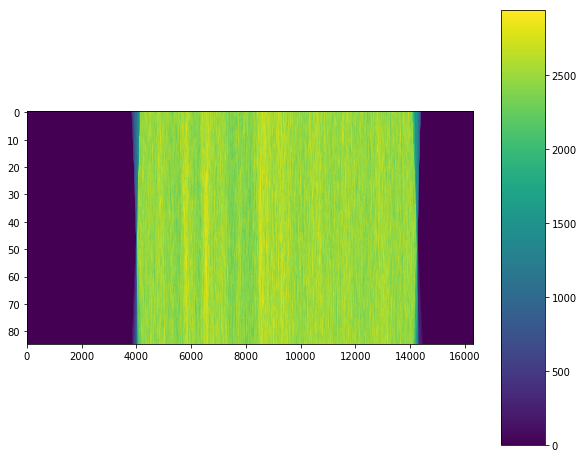

In [7]:
from matplotlib import pyplot
%matplotlib inline
pyplot.figure(figsize=(10, 8))
a = pyplot.imshow(image, aspect = 100)
pyplot.colorbar(shrink = 1,aspect = 10)
#DA METTER IN LOG

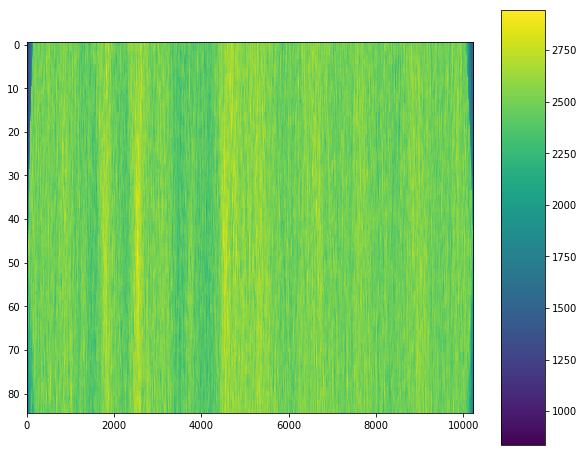

In [39]:
from matplotlib import pyplot
%matplotlib inline
pyplot.figure(figsize=(10, 8))
a = pyplot.imshow(imageCand, aspect = 100)
pyplot.colorbar(shrink = 1,aspect = 10)
#DA METTER IN LOG

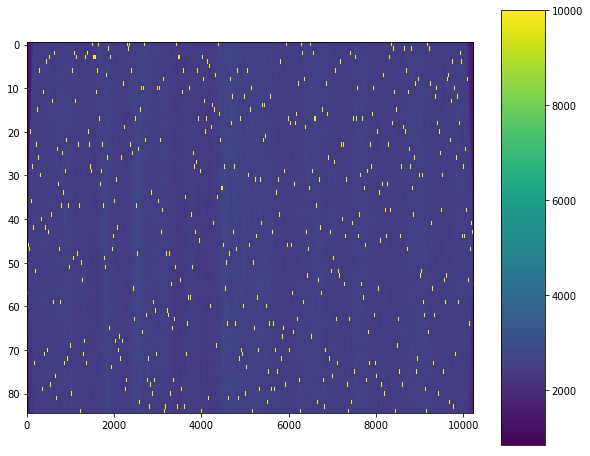

In [105]:
from matplotlib import pyplot
%matplotlib inline
pyplot.figure(figsize=(10, 8))
a = pyplot.imshow(imageCand2, aspect = 100)
pyplot.colorbar(shrink = 1,aspect = 10)
#DA METTER IN LOG

# Numpy

In [2]:
#FIN QUI SOLO HOUGH, ORA CALCOLO CANDS
#per ora numpy
numCand = 100
#if mode = 2
minDistance = enhancement*4

candidati = numpy.zeros((9,numCand*2))

primaFreq = freqIniz-(securbelt/2)*stepFreqRaffinato

#freqIniziale = struttura['basic_info'][0,0]['frin'][0,0][0,0]
#freqFinale = struttura['basic_info'][0,0]['frfi'][0,0][0,0]
freqIniziale = scipy.io.loadmat(percorsoFile)['basic_info'][0,0]['frin'][0,0]
freqFinale = scipy.io.loadmat(percorsoFile)['basic_info'][0,0]['frfi'][0,0]
#QUI ANALOGO FUNZIONE CUT GD2
#%time indexInizialewh = numpy.where(freqniu>freqIniziale)[0][0]
#%time indexFinalewh = numpy.where(freqniu>freqFinale)[0][0]
start = time.time()

indexIniziale = ((freqIniziale-primaFreq)/stepFreqRaffinato).astype(numpy.int64)
indexFinale = ((freqFinale-primaFreq)/stepFreqRaffinato+1).astype(numpy.int64)

imageCand = image[:,indexIniziale:indexFinale]

size = numpy.shape(imageCand)[1]
freqniu = numpy.arange(0,size)*stepFreqRaffinato+freqIniziale

maxPerColumn = numpy.amax(imageCand, axis = 0)
rigaMax = numpy.argmax(imageCand, axis = 0)

#######################

stepFrequenzaNiu = maxPerColumn.size/numCand

indiciFreq = numpy.arange(0,maxPerColumn.size,stepFrequenzaNiu)
indiciFreq = numpy.append(indiciFreq, maxPerColumn.size)
indiciFreq = numpy.round(indiciFreq).astype(numpy.int64)

def statistics(ndArray):
    #ndArray = numpy.ravel(ndArray)
    mediana = numpy.median(ndArray)
    sigmana = numpy.median(numpy.absolute(ndArray-mediana))/0.6745
    return mediana, sigmana

stats = statistics(imageCand)
medianaTot = stats[0]

iniziali = numpy.concatenate(([indiciFreq[0]],indiciFreq[0:numCand-2],[indiciFreq[indiciFreq.size-3]]),0)
finali = numpy.concatenate(([indiciFreq[2]-1],indiciFreq[3:numCand+1]-1,[indiciFreq[indiciFreq.size-1]-1]),0)

def statsPerCand(i):
    stat = statistics(maxPerColumn[iniziali[i]:finali[i]])#[0]
    return stat

statPerCand = numpy.array(list(map(statsPerCand, numpy.arange(numCand))))
medianaPerCand = statPerCand[:,0]
sigmanaPerCand = statPerCand[:,1]
print(medianaPerCand)
print(sigmanaPerCand)
filtro = numpy.where(medianaPerCand > 0)[0]
#medCandFiltrata = medianaPerCand[filtro]
counter = 0
for i in filtro:
    inizio = indiciFreq[i]
    fine = indiciFreq[i+1]-1
    porzioneMaxPerColumn = maxPerColumn[inizio:fine]
    localMax = numpy.amax(porzioneMaxPerColumn)
    localInd = numpy.argmax(porzioneMaxPerColumn)
    if localMax > medianaPerCand[i] and localMax > medianaTot/2:
        counter = counter + 1
        index = indiciFreq[i] + localInd-1
        candidati[0,counter] = freqniu[index]
        candidati[1,counter] = 11 #patch[0]
        candidati[2,counter] = 11 #patch[1]
        riga = rigaMax[index]
        candidati[3,counter] = spindowns[riga]
        candidati[4,counter] = localMax
        candidati[5,counter] = (localMax-medianaPerCand[i])/sigmanaPerCand[i]
        candidati[6,counter] = 11 #patch[2]/2
        candidati[7,counter] = 11 #numpy.abs(patch[3]-patch[4])/4
        candidati[8,counter] = 1
        
        limite1 = numpy.amax([localInd-minDistance,1]).astype(numpy.int32)
        limite2 = numpy.amin([localInd+minDistance,porzioneMaxPerColumn.size]).astype(numpy.int32)
        porzioneMaxPerColumn[limite1:limite2] = 0
        secondLocMax = numpy.amax(porzioneMaxPerColumn)
        secondLocInd = numpy.argmax(porzioneMaxPerColumn)
        
        if numpy.absolute(secondLocInd-localInd) > 2 * minDistance and secondLocMax > medianaPerCand[i]:
            counter = counter + 1
            index = indiciFreq[i] + secondLocInd-1
            candidati[0,counter] = freqniu[index]
            candidati[1,counter] = 11 #patch[0]
            candidati[2,counter] = 11 #patch[1]
            riga = rigaMax[index]
            candidati[3,counter] = spindowns[riga]
            candidati[4,counter] = secondLocMax
            candidati[5,counter] = (secondLocMax-medianaPerCand[i])/sigmanaPerCand[i]
            candidati[6,counter] = 11 #patch[2]/2
            candidati[7,counter] = 11 #numpy.abs(patch[3]-patch[4])/4
            candidati[8,counter] = 2
        
candidati[3,:]=numpy.round(candidati[3,:] / stepSpindown) * stepSpindown
stop = time.time()
print(stop-start)

[ 2616.61181641  2615.61791992  2619.65454102  2616.87646484  2623.24414062
  2625.56347656  2632.90942383  2655.67285156  2657.77734375  2643.05712891
  2608.29589844  2597.43359375  2578.96411133  2565.62207031  2553.23046875
  2596.41552734  2683.85986328  2712.21142578  2691.20019531  2633.99609375
  2582.23754883  2564.85498047  2576.20263672  2685.61010742  2749.21972656
  2746.35351562  2673.77587891  2650.16064453  2644.19067383  2646.80249023
  2643.77441406  2628.38378906  2571.52880859  2525.02197266  2525.77197266
  2552.72558594  2570.42626953  2568.41162109  2537.90014648  2515.89794922
  2515.35351562  2536.03027344  2609.38818359  2710.18896484  2765.26855469
  2769.2265625   2735.12841797  2709.10302734  2693.44384766  2693.04882812
  2706.86767578  2726.88305664  2722.94970703  2693.06787109  2664.75927734
  2636.40161133  2611.23510742  2601.33349609  2591.52734375  2601.60229492
  2614.1796875   2639.13525391  2660.09375     2677.13378906  2687.8918457
  2683.416015

In [3]:
print(candidati.shape)

(9, 200)


In [ ]:
for i in numpy.arange(1,numCand-1):
    inizio = indiciFreq[i-1]
    fine = indiciFreq[i+2]-1
    medianaPerCand[i] = stats(maxPerColumn[inizio:fine])[0]
    sigmanaPerCand[i] = stats(maxPerColumn[inizio:fine])[1]

i = 1
inizio = indiciFreq[i-1]
fine = indiciFreq[i+1]-1
medianaPerCand[0] = stats(maxPerColumn[inizio:fine])[0]
sigmanaPerCand[0] = stats(maxPerColumn[inizio:fine])[1]

i = indiciFreq.size-2
inizio = indiciFreq[i-2]
fine = indiciFreq[i]-1
medianaPerCand[numCand-1] = stats(maxPerColumn[inizio:fine])[0]
sigmanaPerCand[numCand-1] = stats(maxPerColumn[inizio:fine])[1]
